In [1]:
#%pip install -U pretty_midi
#%pip install matplotlib
#%pip install seaborn
import pretty_midi
import os
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib import cm

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix,accuracy_score, f1_score,classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, LabelEncoder

from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, BatchNormalization, Dropout, Activation
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [2]:
data_dir = "Four_composers"

### Extract the relevant features from each MIDI file. Store the features in a list X, and the associated composer in a list y. 

In [3]:
import warnings

def extract_features(midi_file):
    try:
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=RuntimeWarning, message="Tempo, Key or Time signature change events found on non-zero tracks")
            midi_data = pretty_midi.PrettyMIDI(midi_file)
    except IOError as e:
        print(f"Error reading file {midi_file}: {str(e)}")
        return None
    except Exception as e:
        print(f"Error parsing MIDI file {midi_file}: {str(e)}")
        return None

    try:
        tempo_changes = midi_data.get_tempo_changes()
        tempo = tempo_changes[1][0] if len(tempo_changes) > 1 and len(tempo_changes[1]) > 0 else 120
    except IndexError:
        tempo = 120

    num_instruments = len(midi_data.instruments)
    
    total_velocity = 0
    total_notes = 0
    for instrument in midi_data.instruments:
        total_velocity += sum(note.velocity for note in instrument.notes)
        total_notes += len(instrument.notes)
    
    avg_velocity = total_velocity / total_notes if total_notes > 0 else 0
    
    pitch_classes = [0] * 12
    for instrument in midi_data.instruments:
        for note in instrument.notes:
            pitch_classes[note.pitch % 12] += 1
    
    # Ignore key signature errors
    try:
        key = midi_data.key_signature_changes[0].key_number if midi_data.key_signature_changes else 0
    except (ValueError, IndexError):
        key = 0

    return [tempo, num_instruments, avg_velocity, key] + pitch_classes

X = []
y = []
error_count = 0
for composer in os.listdir(data_dir):
    composer_dir = os.path.join(data_dir, composer)
    if os.path.isdir(composer_dir):
        for root, dirs, files in os.walk(composer_dir):
            for midi_file in files:
                if midi_file.endswith('.mid'):
                    file_path = os.path.join(root, midi_file)
                    features = extract_features(file_path)
                    if features is not None:
                        X.append(features)
                        y.append(composer)
                    else:
                        error_count += 1
                        print(f"Skipping file {file_path} due to errors")

if error_count == 0:
    print("No errors found in dataset.")

No errors found in dataset.


### Convert X into an array. Perform train-test split.

In [4]:
X_np = np.array(X)
y_np = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X_np, y_np, test_size=0.2)

### Print raw values of X_train and X_test to visualize range

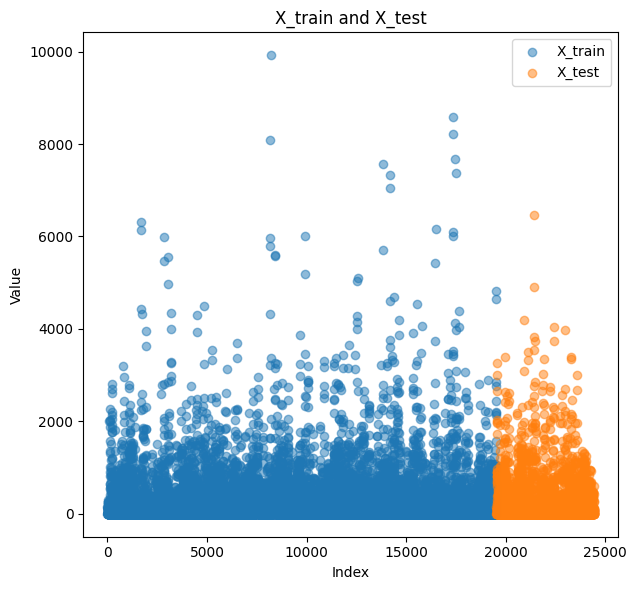

In [5]:
plt.figure(figsize=(12, 6))

# Function to flatten 2D data if necessary
def flatten_if_needed(data):
    if len(data.shape) > 1 and data.shape[1] > 1:
        return data.flatten()
    return data

# Plot X_train and X_test
plt.subplot(1, 2, 1)
X_train_flat = flatten_if_needed(X_train)
X_test_flat = flatten_if_needed(X_test)

plt.scatter(range(len(X_train_flat)), X_train_flat, alpha=0.5, label='X_train')
plt.scatter(range(len(X_train_flat), len(X_train_flat) + len(X_test_flat)), X_test_flat, alpha=0.5, label='X_test')
plt.title('X_train and X_test')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()

plt.tight_layout()
plt.show()

### Extreme range calls for Standard Scaling on X_train and X_test.

In [6]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [7]:
print(X_train_scaled.shape)
print(X_test_scaled.shape)

(1221, 16)
(306, 16)


### SMOTE resampling on the training sets

In [8]:
#%pip install -U -q imbalanced-learn
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_scaled_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

### Visualize the data imbalance, and correction after SMOTE.

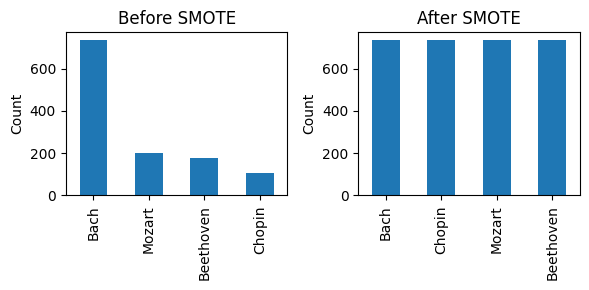

In [9]:
# Convert y_train and y_train_smote to pandas Series
y_train_series = pd.Series(y_train)
y_train_smote_series = pd.Series(y_train_smote)

f = plt.figure(figsize=(6, 3))
plt.subplots_adjust(wspace=0.3, hspace=0.5)

# Plot before SMOTE
ax1 = f.add_subplot(1, 2, 1)
y_train_series.value_counts().plot(kind='bar', ax=ax1)
ax1.set_title("Before SMOTE")
ax1.set_ylabel("Count")

# Plot after SMOTE
ax2 = f.add_subplot(1, 2, 2)
y_train_smote_series.value_counts().plot(kind='bar', ax=ax2)
ax2.set_title("After SMOTE")
ax2.set_ylabel("Count")

plt.tight_layout()
plt.show()

In [10]:
print(y_train_smote.shape)
print(y_test.shape)

(2944,)
(306,)


### SVM

In [11]:
# Train a Support Vector Machine classifier
svm_clf = SVC(kernel='rbf', gamma=0.4, degree=5, C=18.0, decision_function_shape='ovr')
svm_clf.fit(X_train_scaled_smote, y_train_smote)

SVC(C=18.0, degree=5, gamma=0.4)

### Train model using radial basis vector kernel.

In [12]:
y_pred = svm_clf.predict(X_test_scaled)
rbf_accuracy = accuracy_score(y_test, y_pred)
rbf_f1 = f1_score(y_test, y_pred, average='weighted')
print('Accuracy (RBF Kernel): ', "%.2f" % (rbf_accuracy*100))
print('F1 (RBF Kernel): ', "%.2f" % (rbf_f1*100))

Accuracy (RBF Kernel):  73.20
F1 (RBF Kernel):  74.18


In [13]:
# Generate and print the classification report
report = classification_report(y_test, y_pred, zero_division=1)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

        Bach       0.91      0.86      0.88       189
   Beethoven       0.37      0.50      0.42        36
      Chopin       0.73      0.57      0.64        28
      Mozart       0.49      0.53      0.51        53

    accuracy                           0.73       306
   macro avg       0.62      0.61      0.61       306
weighted avg       0.76      0.73      0.74       306



### Print confusion matrix.

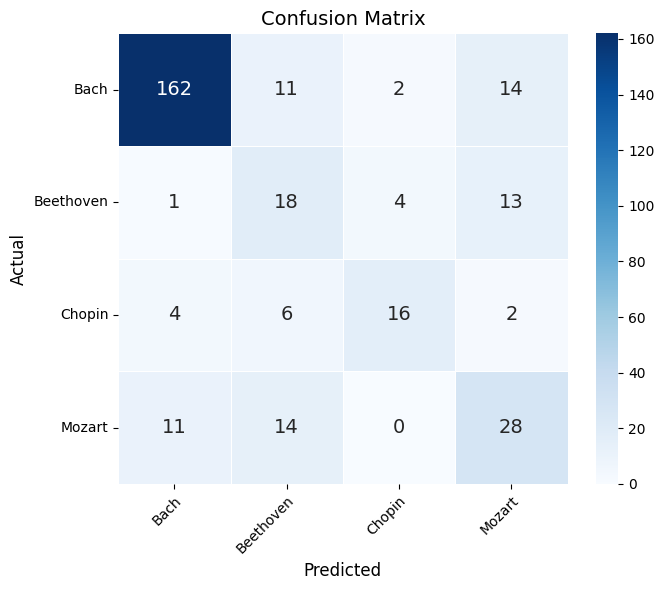

In [14]:
labels = sorted(set(y_test) | set(y_pred))

cmatrix = confusion_matrix(y_test, y_pred, labels=labels)
fontsize = 7
figsize = (7, 6)  # Increased figure size for better readability
cmap = plt.colormaps.get_cmap("Blues")
fig, ax = plt.subplots(figsize=figsize)

sns.heatmap(cmatrix, 
            annot=True, 
            cmap=cmap, 
            cbar=True, 
            ax=ax, 
            linewidths=0.5,
            fmt='d',
            annot_kws={'fontsize': 14},
            xticklabels=labels,
            yticklabels=labels)

plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix', fontsize=14)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.setp(ax.get_yticklabels(), rotation=0, ha="right")

plt.tight_layout()
plt.show()

### LSTM

#### Reshape X train and X test

In [15]:
num_classes = len(np.unique(y_train_smote))
X_train_reshaped = X_train_scaled_smote.reshape((X_train_scaled_smote.shape[0], X_train_scaled_smote.shape[1], 1))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

input_shape = (X_train_scaled_smote.shape[1], 1)

In [16]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_smote)
y_test_encoded  = label_encoder.transform(y_test)

y_train_categorical = to_categorical(y_train_encoded, num_classes)
y_test_categorical = to_categorical(y_test_encoded, num_classes)

In [17]:
def create_sequences(data, labels, sequence_length):
    sequences = []
    sequence_labels = []
    for i in range(data.shape[0] - sequence_length + 1):
        seq = data[i:i+sequence_length]
        label = labels[i+sequence_length-1]  # Use the label of the last timestep in the sequence
        sequences.append(seq)
        sequence_labels.append(label)
    return np.array(sequences), np.array(sequence_labels)

sequence_length = 5  # You can adjust this
X_train_seq, y_train_seq = create_sequences(X_train_reshaped, y_train_categorical, sequence_length)

X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))
X_test_seq, y_test_seq  = create_sequences(X_test_reshaped, y_test_categorical, sequence_length)

#### Encode target variable

In [18]:
#label_encoder = LabelEncoder()
#y_encoded = label_encoder.fit_transform(y)

#### Build and train model

In [19]:
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras import regularizers
from tensorflow.keras.callbacks import Callback

lstm_model = Sequential([
    Input(shape=(sequence_length, X_train_seq.shape[2])),
    BatchNormalization(),
    LSTM(15, return_sequences=True,recurrent_dropout=0.7),
    BatchNormalization(),
    Dropout(0.6),
    
    BatchNormalization(),
    LSTM(5, return_sequences=False,recurrent_dropout=0.7),
    BatchNormalization(),
    Dropout(0.6),

#    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.03)),
#    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.03)),
    
    # Output layer
    Dense(num_classes, activation='softmax')
])

# Compile the model
lstm_model.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=30, min_lr=1e-4, verbose=1)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True, verbose=1)

# Print statistics every 5 epochs to decrease training clutter
class EpochPrintCallback(Callback):
    def __init__(self, print_every=5):
        super(EpochPrintCallback, self).__init__()
        self.print_every = print_every

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.print_every == 0:
            print(f"\nEpoch {epoch + 1}/{self.params['epochs']}")
            print(f"loss: {logs['loss']:.4f} - accuracy: {logs['accuracy']:.4f} - val_loss: {logs['val_loss']:.4f} - val_accuracy: {logs['val_accuracy']:.4f}")
epoch_print = EpochPrintCallback(print_every=10)

# Train the model
result = lstm_model.fit(X_train_seq, y_train_seq, validation_data=(X_test_seq, y_test_seq), epochs=1000,  # Set a higher number, early stopping will prevent overfitting
    batch_size=32, callbacks=[lr_scheduler, early_stopping, epoch_print], verbose=0)


Epoch 10/1000
loss: 0.8713 - accuracy: 0.6088 - val_loss: 0.8406 - val_accuracy: 0.6689

Epoch 20/1000
loss: 0.8462 - accuracy: 0.6129 - val_loss: 0.9411 - val_accuracy: 0.6490

Epoch 30/1000
loss: 0.8075 - accuracy: 0.6456 - val_loss: 0.8214 - val_accuracy: 0.6722

Epoch 40/1000
loss: 0.7564 - accuracy: 0.6571 - val_loss: 0.8030 - val_accuracy: 0.6755

Epoch 50/1000
loss: 0.7917 - accuracy: 0.6473 - val_loss: 0.8158 - val_accuracy: 0.6722

Epoch 60/1000
loss: 0.7874 - accuracy: 0.6418 - val_loss: 0.7950 - val_accuracy: 0.6689

Epoch 70/1000
loss: 0.7628 - accuracy: 0.6544 - val_loss: 0.7776 - val_accuracy: 0.7020

Epoch 80/1000
loss: 0.7714 - accuracy: 0.6439 - val_loss: 0.7828 - val_accuracy: 0.6623

Epoch 90/1000
loss: 0.7534 - accuracy: 0.6690 - val_loss: 0.8036 - val_accuracy: 0.6887

Epoch 96: ReduceLROnPlateau reducing learning rate to 0.005999999865889549.

Epoch 100/1000
loss: 0.7128 - accuracy: 0.6745 - val_loss: 0.7694 - val_accuracy: 0.7185

Epoch 110/1000
loss: 0.7283 - a

#### Evaluate training

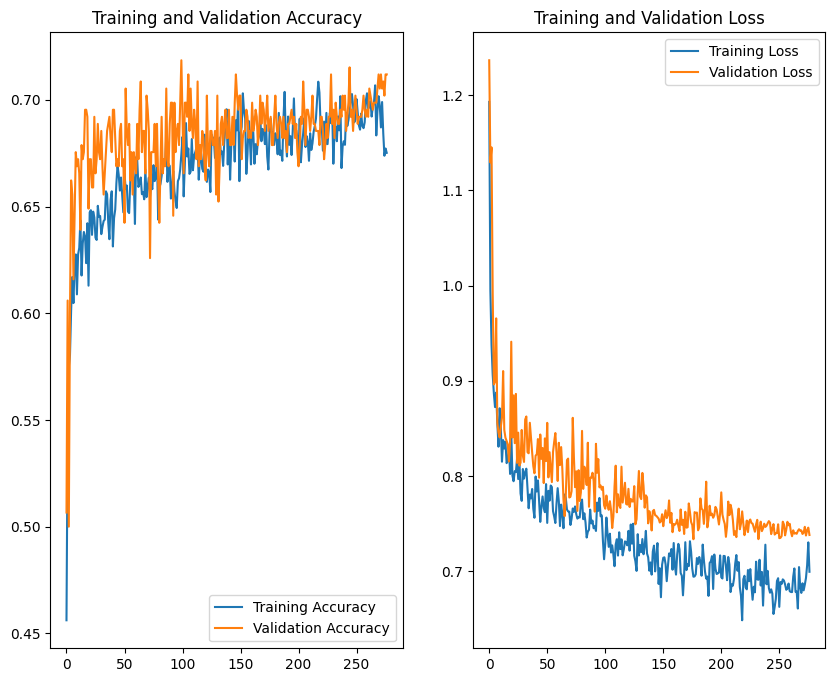

In [20]:
acc = result.history['accuracy']
val_acc = result.history['val_accuracy']

loss = result.history['loss']
val_loss = result.history['val_loss']

epochs_range = range(len(acc)) 

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Make predictions

In [21]:
lstm_model.training=False
y_pred = lstm_model.predict(X_test_seq)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_seq, axis=1)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [22]:
# Convert y_test_categorical back to class labels
y_test_classes = np.argmax(y_test_seq, axis=1)

# Generate the classification report
report = classification_report(y_test_classes, y_pred_classes, zero_division=1)

# Print the report
print(report)

              precision    recall  f1-score   support

           0       0.78      0.90      0.83       186
           1       0.36      0.36      0.36        36
           2       0.78      0.52      0.62        27
           3       0.44      0.28      0.34        53

    accuracy                           0.69       302
   macro avg       0.59      0.52      0.54       302
weighted avg       0.67      0.69      0.67       302



### Print Confusion matrix

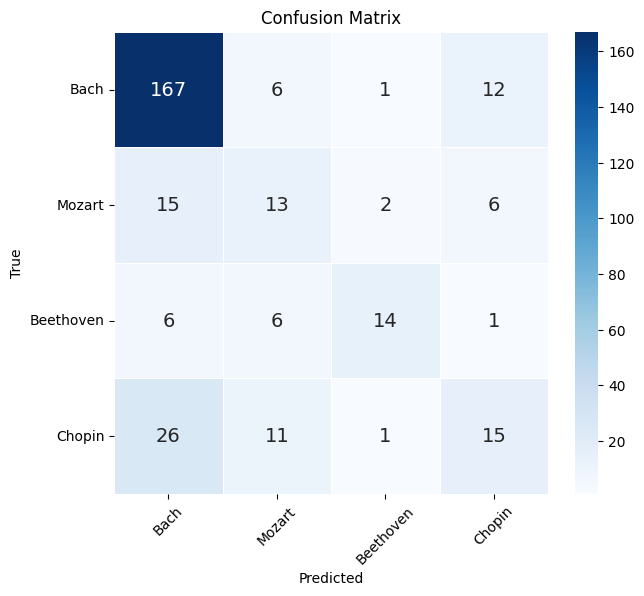

<Figure size 1000x800 with 0 Axes>

In [23]:
# Compute confusion matrix
cmatrix_lstm = confusion_matrix(y_true, y_pred_classes)
fontsize = 7
figsize = (7, 6)  # Increased figure size for better readability

# Create a pyplot figure
class_names = ['Bach', 'Mozart', 'Beethoven', 'Chopin']
fig, ax = plt.subplots(figsize=figsize)
plt.figure(figsize=(10, 8))
cmap = plt.colormaps.get_cmap("Blues")

# Create the confusion matrix heatmap
sns.heatmap(cmatrix_lstm, 
            annot=True, 
            cmap=cmap, 
            cbar=True, 
            ax=ax, 
            linewidths=0.5,
            fmt='d',
            annot_kws={'fontsize': 14})

# Set labels and title
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
ax.set_xticks(np.arange(len(class_names)) + 0.5)
ax.set_yticks(np.arange(len(class_names)) + 0.5)
ax.set_xticklabels(class_names, rotation=45)
ax.set_yticklabels(class_names, rotation=0)

# Show the plot
plt.show()

### CNN

#### Build model and train

In [24]:
cnn_model = Sequential([
    # Input normalization
    BatchNormalization(input_shape=input_shape),
    
    # First convolutional block
    Conv1D(64, kernel_size=3, padding='same'),
    BatchNormalization(),
    Conv1D(64, kernel_size=3, padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    
    # Second convolutional block
    Conv1D(128, kernel_size=3, padding='same'),
    BatchNormalization(),
    Conv1D(128, kernel_size=3, padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    
    # Third convolutional block
    Conv1D(256, kernel_size=3, padding='same'),
    BatchNormalization(),
    Conv1D(256, kernel_size=3, padding='same'),
    BatchNormalization(),
    GlobalAveragePooling1D(),
    Dropout(0.4),
    
    # Dense layers
    Dense(128, activation="relu"),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(64, activation="relu"),
    BatchNormalization(),
    Dropout(0.5),
    
    # Output layer
    Dense(num_classes, activation='softmax')
])

# Compile the model
cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

# Train the model
result = cnn_model.fit(X_train_reshaped, y_train_categorical, validation_split=0.1, epochs=100,  # Set a higher number, early stopping will prevent overfitting
    batch_size=32, callbacks=[lr_scheduler, early_stopping])

Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/normalization/batch_normalization.py:143: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.3806 - loss: 1.8084 - val_accuracy: 0.0712 - val_loss: 1.7753 - learning_rate: 0.0010
Epoch 2/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5461 - loss: 1.3030 - val_accuracy: 0.0271 - val_loss: 1.9279 - learning_rate: 0.0010
Epoch 3/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5820 - loss: 1.0998 - val_accuracy: 0.0339 - val_loss: 1.9582 - learning_rate: 0.0010
Epoch 4/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6112 - loss: 1.0127 - val_accuracy: 0.3627 - val_loss: 1.3008 - learning_rate: 0.0010
Epoch 5/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6394 - loss: 0.9131 - val_accuracy: 0.2542 - val_loss: 1.3442 - learning_rate: 0.0010
Epoch 6/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6604 - loss: 0.8682 - val_accuracy: 0.5017 - val_loss: 1.0042 - learning_rate: 0.0010
Epoch 7/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6855 - loss: 0.8081 - val_accuracy: 0.60

#### Evaluate training

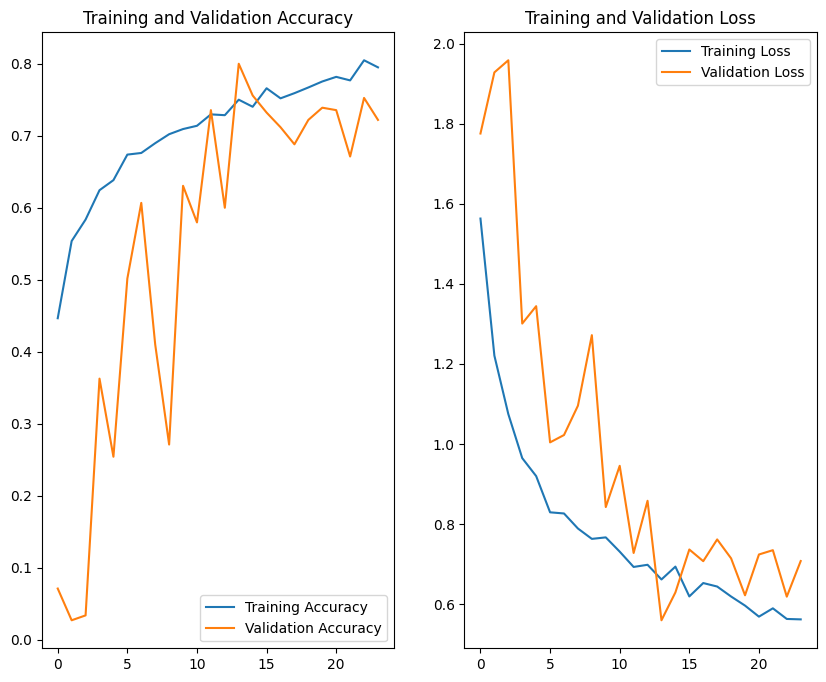

In [25]:
acc = result.history['accuracy']
val_acc = result.history['val_accuracy']

loss = result.history['loss']
val_loss = result.history['val_loss']

epochs_range = range(len(acc)) 

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Make predictions

In [26]:
y_pred = cnn_model.predict(X_test_reshaped)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [27]:
# Convert y_pred from probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert y_test_categorical back to class labels
y_test_classes = np.argmax(y_test_categorical, axis=1)

# Generate the classification report
report = classification_report(y_test_classes, y_pred_classes, zero_division=1)

# Print the report
print(report)

              precision    recall  f1-score   support

           0       0.94      0.78      0.86       189
           1       0.36      0.53      0.43        36
           2       0.51      0.64      0.57        28
           3       0.61      0.70      0.65        53

    accuracy                           0.73       306
   macro avg       0.61      0.66      0.63       306
weighted avg       0.78      0.73      0.74       306



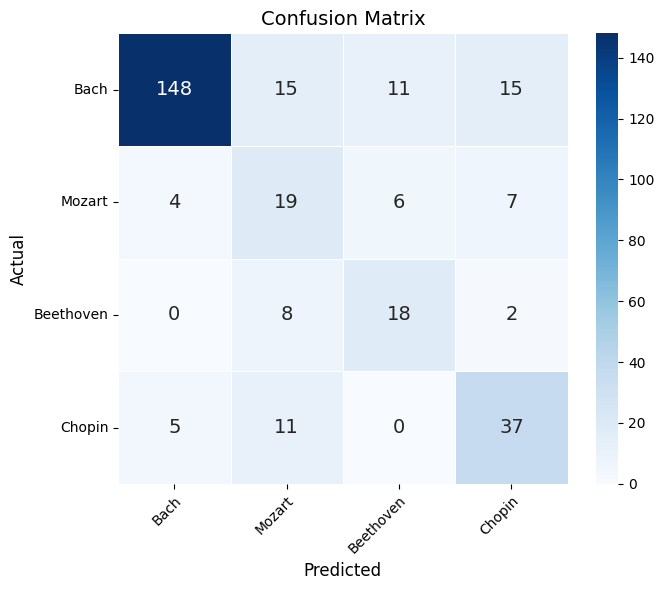

In [39]:
cmatrix_cnn = confusion_matrix(y_test_classes, y_pred_classes)
fontsize = 7
figsize = (7, 6)
cmap = plt.colormaps.get_cmap("Blues")
fig, ax = plt.subplots(figsize=figsize)

sns.heatmap(cmatrix_cnn, 
            annot=True, 
            cmap=cmap, 
            cbar=True, 
            ax=ax, 
            linewidths=0.5,
            fmt='d',
            annot_kws={'fontsize': 14},
            xticklabels=labels,
            yticklabels=labels)

plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix', fontsize=14)

ax.set_xticklabels(class_names, rotation=45)
ax.set_yticklabels(class_names, rotation=0)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.setp(ax.get_yticklabels(), rotation=0, ha="right")

plt.tight_layout()
plt.show()